<a href="https://colab.research.google.com/github/0xfffddd/Coding/blob/main/TransHW3code_SQL_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAIM Spark Assignment — Spark SQL Notebook
This notebook implements **Spark SQL** for each question.
Assumption: you already created Databricks tables in `workspace.default`.


In [ ]:
#pre-processing
# Create temp views.
spark.table("workspace.default.olist_orders_dataset").createOrReplaceTempView("orders")
spark.table("workspace.default.olist_order_payments_dataset").createOrReplaceTempView("payments")
spark.table("workspace.default.olist_customers_dataset").createOrReplaceTempView("customers")
spark.table("workspace.default.olist_products_dataset").createOrReplaceTempView("products")
spark.table("workspace.default.olist_order_reviews_dataset").createOrReplaceTempView("reviews_raw")
spark.table("workspace.default.olist_order_items_dataset").createOrReplaceTempView("order_items")


## Q1. Data Exploration & Preprocessing
1) Load datasets into DataFrames (done via temp views)
2) Display schema and sample records
3) Count the number of unique orders and customers


In [ ]:
spark.sql("DESCRIBE TABLE orders").show(truncate=False)
spark.sql("SELECT * FROM orders LIMIT 5").show(truncate=False)

spark.sql("DESCRIBE TABLE payments").show(truncate=False)
spark.sql("SELECT * FROM payments LIMIT 5").show(truncate=False)

spark.sql("DESCRIBE TABLE customers").show(truncate=False)
spark.sql("SELECT * FROM customers LIMIT 5").show(truncate=False)

spark.sql("DESCRIBE TABLE products").show(truncate=False)
spark.sql("SELECT * FROM products LIMIT 5").show(truncate=False)

spark.sql("DESCRIBE TABLE reviews_raw").show(truncate=False)
spark.sql("SELECT * FROM reviews_raw LIMIT 5").show(truncate=False)

spark.sql("""
SELECT COUNT(DISTINCT order_id) AS unique_orders
FROM orders
""").show()

spark.sql("""
SELECT COUNT(DISTINCT customer_unique_id) AS unique_customers
FROM customers
""").show()

+-----------------------------+---------+-------+
|col_name                     |data_type|comment|
+-----------------------------+---------+-------+
|order_id                     |string   |NULL   |
|customer_id                  |string   |NULL   |
|order_status                 |string   |NULL   |
|order_purchase_timestamp     |timestamp|NULL   |
|order_approved_at            |timestamp|NULL   |
|order_delivered_carrier_date |timestamp|NULL   |
|order_delivered_customer_date|timestamp|NULL   |
|order_estimated_delivery_date|timestamp|NULL   |
+-----------------------------+---------+-------+

+--------------------------------+--------------------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|order_id                        |customer_id                     |order_status|order_purchase_timestamp|order_approved_at  |order_delivered_carrier_date|order_delivered_customer_date|

### Helper Views (used in later questions)

## Q2. Sales & Revenue Analysis
4) Total revenue, average order value, monthly revenue trends
5) Top 5 best-selling product categories
6) Top 3 payment methods


In [ ]:
#pre-processing before Q2
# Payments aggregated per order
spark.sql("""
CREATE OR REPLACE TEMP VIEW order_value AS
SELECT
  order_id,
  SUM(payment_value) AS total_order_value
FROM payments
GROUP BY order_id
""")
# Latest review per order (dedupe)
spark.sql("""
CREATE OR REPLACE TEMP VIEW reviews AS
SELECT *
FROM (
  SELECT
    r.*,
    ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY review_creation_date DESC) AS rn
  FROM reviews_raw r
) t
WHERE rn = 1
""")
# Delivered orders with shipping days + delay days
spark.sql("""
CREATE OR REPLACE TEMP VIEW delivered_orders AS
SELECT
  order_id,
  customer_id,
  order_purchase_timestamp,
  order_delivered_customer_date,
  order_estimated_delivery_date,
  (unix_timestamp(order_delivered_customer_date) - unix_timestamp(order_purchase_timestamp)) / 86400.0 AS shipping_days,
  (unix_timestamp(order_delivered_customer_date) - unix_timestamp(order_estimated_delivery_date)) / 86400.0 AS delay_days
FROM orders
WHERE order_status = 'delivered'
  AND order_purchase_timestamp IS NOT NULL
  AND order_delivered_customer_date IS NOT NULL
  AND order_estimated_delivery_date IS NOT NULL
""")

print("Helper views ready: order_value, reviews (deduped), delivered_orders")

# 4) total revenue + AOV
spark.sql("""
SELECT
  SUM(payment_value) AS total_revenue,
  SUM(payment_value) / COUNT(DISTINCT order_id) AS avg_order_value
FROM payments
""").show()

# 4) monthly revenue trend (delivered only)
spark.sql("""
SELECT
  date_format(o.order_purchase_timestamp, 'yyyy-MM') AS year_month,
  SUM(p.payment_value) AS monthly_revenue,
  COUNT(DISTINCT o.order_id) AS num_orders
FROM orders o
JOIN payments p USING (order_id)
WHERE o.order_status = 'delivered'
GROUP BY date_format(o.order_purchase_timestamp, 'yyyy-MM')
ORDER BY year_month
""").show(200, truncate=False)

# 5) top 5 best-selling categories (by item count)
spark.sql("""
SELECT
  pr.product_category_name,
  COUNT(*) AS sales_count
FROM order_items oi
JOIN products pr USING (product_id)
GROUP BY pr.product_category_name
ORDER BY sales_count DESC
LIMIT 5
""").show(truncate=False)

# 6) top 3 payment methods
spark.sql("""
SELECT
  payment_type,
  COUNT(*) AS usage_count
FROM payments
GROUP BY payment_type
ORDER BY usage_count DESC
LIMIT 3
""").show(truncate=False)

Helper views ready: order_value, reviews (deduped), delivered_orders
+--------------------+-----------------+
|       total_revenue|  avg_order_value|
+--------------------+-----------------+
|1.6008872119998736E7|160.9902666934708|
+--------------------+-----------------+

+----------+------------------+----------+
|year_month|monthly_revenue   |num_orders|
+----------+------------------+----------+
|2016-10   |46566.71000000003 |265       |
|2016-12   |19.62             |1         |
|2017-01   |127545.67000000003|750       |
|2017-02   |271298.64999999973|1653      |
|2017-03   |414369.39000000065|2546      |
|2017-04   |390952.17999999935|2303      |
|2017-05   |567066.7300000021 |3546      |
|2017-06   |490225.60000000295|3135      |
|2017-07   |566403.9300000035 |3872      |
|2017-08   |646000.6100000024 |4193      |
|2017-09   |701169.9899999999 |4150      |
|2017-10   |751140.2700000027 |4478      |
|2017-11   |1153528.0499999977|7289      |
|2017-12   |843199.1699999985 |5513  

## Q3. Customer Behavior Analysis
7) Average orders per customer
8) Top 5 cities with most purchases
9) Segment customers by purchase frequency
**Use `customer_unique_id` as the real customer identifier.**


In [ ]:
#pre-processing before Q3
# Customer-level order counts (real customers)
spark.sql("""
CREATE OR REPLACE TEMP VIEW orders_by_customer AS
SELECT
  c.customer_unique_id,
  COUNT(DISTINCT o.order_id) AS order_count
FROM orders o
JOIN customers c USING (customer_id)
GROUP BY c.customer_unique_id
""")

# 7)
spark.sql("""
SELECT AVG(order_count) AS avg_orders_per_customer
FROM orders_by_customer
""").show()

# 8)
spark.sql("""
SELECT
  c.customer_city,
  COUNT(DISTINCT o.order_id) AS num_orders
FROM orders o
JOIN customers c USING (customer_id)
GROUP BY c.customer_city
ORDER BY num_orders DESC
LIMIT 5
""").show(truncate=False)

# 9)
spark.sql("""
SELECT
  CASE
    WHEN order_count = 1 THEN 'one-time'
    WHEN order_count BETWEEN 2 AND 5 THEN 'occasional'
    WHEN order_count BETWEEN 6 AND 15 THEN 'frequent'
    ELSE 'loyal'
  END AS customer_segment,
  COUNT(*) AS num_customers
FROM orders_by_customer
GROUP BY
  CASE
    WHEN order_count = 1 THEN 'one-time'
    WHEN order_count BETWEEN 2 AND 5 THEN 'occasional'
    WHEN order_count BETWEEN 6 AND 15 THEN 'frequent'
    ELSE 'loyal'
  END
ORDER BY num_customers DESC
""").show(truncate=False)

+-----------------------+
|avg_orders_per_customer|
+-----------------------+
|     1.0348089410589412|
+-----------------------+

+--------------+----------+
|customer_city |num_orders|
+--------------+----------+
|sao paulo     |15540     |
|rio de janeiro|6882      |
|belo horizonte|2773      |
|brasilia      |2131      |
|curitiba      |1521      |
+--------------+----------+

+----------------+-------------+
|customer_segment|num_customers|
+----------------+-------------+
|one-time        |93099        |
|occasional      |2986         |
|frequent        |10           |
|loyal           |1            |
+----------------+-------------+



## Q4. Delivery & Logistics Analysis
10) Average shipping time per order
11) Top 10 worst delays
12) Regions (states) with longest shipping times


In [ ]:
# 10
spark.sql("""
SELECT AVG(shipping_days) AS avg_shipping_days
FROM delivered_orders
""").show()

# 11
spark.sql("""
SELECT
  order_id,
  customer_id,
  ROUND(shipping_days, 2) AS shipping_days,
  ROUND(delay_days, 2) AS delay_days,
  order_purchase_timestamp,
  order_estimated_delivery_date,
  order_delivered_customer_date
FROM delivered_orders
WHERE delay_days > 0
ORDER BY delay_days DESC
LIMIT 10
""").show(truncate=False)

# 12
spark.sql("""
SELECT
  c.customer_state,
  ROUND(AVG(d.shipping_days), 2) AS avg_shipping_days,
  COUNT(*) AS num_orders
FROM delivered_orders d
JOIN customers c USING (customer_id)
GROUP BY c.customer_state
ORDER BY avg_shipping_days DESC
""").show(100, truncate=False)

+-----------------+
|avg_shipping_days|
+-----------------+
|   12.55821709818|
+-----------------+

+--------------------------------+--------------------------------+-------------+----------+------------------------+-----------------------------+-----------------------------+
|order_id                        |customer_id                     |shipping_days|delay_days|order_purchase_timestamp|order_estimated_delivery_date|order_delivered_customer_date|
+--------------------------------+--------------------------------+-------------+----------+------------------------+-----------------------------+-----------------------------+
|1b3190b2dfa9d789e1f14c05b647a14a|d306426abe5fca15e54b645e4462dc7b|208.35       |188.98    |2018-02-23 14:57:35     |2018-03-15 00:00:00          |2018-09-19 23:24:07          |
|ca07593549f1816d26a572e06dc1eab6|75683a92331068e2d281b11a7866ba44|209.63       |181.61    |2017-02-21 23:31:27     |2017-03-22 00:00:00          |2017-09-19 14:36:39          |
|47b40429

## Q5. Customer Reviews & Satisfaction
13) Distribution of review scores
13.1) Count and percentage per score
13.2) Bar chart
14) % low (1-2) vs high (4-5)
15) Low-rated (1-2) top words/phrases; translated insights


In [ ]:
# 13.1
spark.sql("""
WITH base AS (
  SELECT CAST(review_score AS INT) AS review_score
  FROM reviews
  WHERE review_score IS NOT NULL
),
counts AS (
  SELECT review_score, COUNT(*) AS cnt
  FROM base
  GROUP BY review_score
),
tot AS (SELECT SUM(cnt) AS total FROM counts)
SELECT
  c.review_score,
  c.cnt AS count,
  ROUND(c.cnt * 100.0 / t.total, 2) AS percentage
FROM counts c CROSS JOIN tot t
ORDER BY c.review_score
""").show(truncate=False)

+------------+-----+----------+
|review_score|count|percentage|
+------------+-----+----------+
|0           |1    |0.00      |
|1           |11359|11.51     |
|2           |3127 |3.17      |
|3           |8135 |8.24      |
|4           |19047|19.30     |
|5           |57005|57.77     |
+------------+-----+----------+



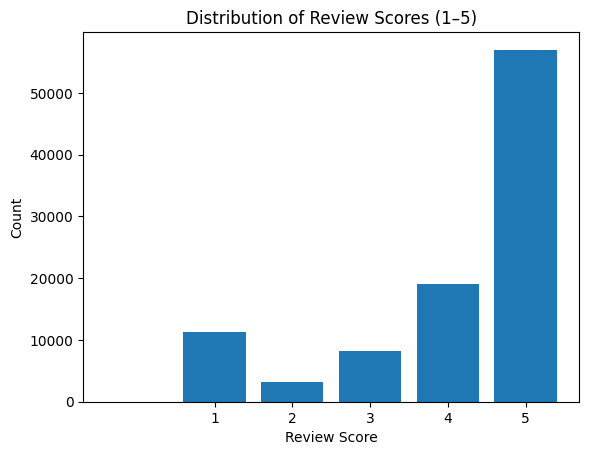

In [ ]:
# 13.2 (visualization from SQL output)
import matplotlib.pyplot as plt

score_dist = spark.sql("""
WITH base AS (
  SELECT CAST(review_score AS INT) AS review_score
  FROM reviews
  WHERE review_score IS NOT NULL
)
SELECT review_score, COUNT(*) AS count
FROM base
GROUP BY review_score
ORDER BY review_score
""")

pdf = score_dist.toPandas()

plt.figure()
plt.bar(pdf["review_score"], pdf["count"])
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores (1–5)")
plt.xticks([1,2,3,4,5])
plt.show()

In [ ]:
# 14
spark.sql("""
WITH base AS (
  SELECT CAST(review_score AS INT) AS review_score
  FROM reviews
  WHERE review_score IS NOT NULL
),
bucketed AS (
  SELECT
    CASE
      WHEN review_score IN (1,2) THEN 'low (1-2)'
      WHEN review_score IN (4,5) THEN 'high (4-5)'
      ELSE 'mid (3)'
    END AS bucket
  FROM base
),
counts AS (
  SELECT bucket, COUNT(*) AS cnt
  FROM bucketed
  GROUP BY bucket
),
tot AS (SELECT SUM(cnt) AS total FROM counts)
SELECT
  c.bucket,
  c.cnt AS count,
  ROUND(c.cnt * 100.0 / t.total, 2) AS percentage
FROM counts c CROSS JOIN tot t
ORDER BY c.bucket
""").show(truncate=False)

+----------+-----+----------+
|bucket    |count|percentage|
+----------+-----+----------+
|high (4-5)|76052|77.07     |
|low (1-2) |14486|14.68     |
|mid (3)   |8136 |8.25      |
+----------+-----+----------+



In [ ]:
# 15.1 Top 10 words (SQL)
spark.sql("""
WITH low AS (
  SELECT LOWER(review_comment_message) AS msg
  FROM reviews
  WHERE CAST(review_score AS INT) IN (1,2)
    AND review_comment_message IS NOT NULL
),
clean AS (
  SELECT regexp_replace(msg, '[^\\p{L} ]', ' ') AS msg2
  FROM low
),
tokens AS (
  SELECT explode(split(regexp_replace(msg2, ' +', ' '), ' ')) AS token
  FROM clean
),
filtered AS (
  SELECT token
  FROM tokens
  WHERE token IS NOT NULL
    AND length(token) >= 3
    AND token NOT IN ('a', 'o', 'os', 'as', 'um', 'uma', 'uns', 'umas', 'de', 'da', 'do', 'das', 'dos', 'e', 'é', 'em', 'no', 'na', 'nos', 'nas', 'para', 'por', 'com', 'sem', 'que', 'não', 'sim', 'mais', 'muito', 'muita', 'meu', 'minha', 'se', 'já', 'foi', 'ser', 'ao', 'à', 'pra', 'porque', 'como', 'mas', 'bem', 'só', 'tá', 'está', 'estava', 'estão', 'eu', 'vc', 'vcs', 'você', 'vocês', 'também', 'ainda', 'm', 'q')
)
SELECT token AS word, COUNT(*) AS freq
FROM filtered
GROUP BY token
ORDER BY freq DESC
LIMIT 10
""").show(truncate=False)

+----+----+
|word|freq|
+----+----+
+----+----+



In [ ]:
# 15.1 Top 10 phrases/bigrams (SQL)
spark.sql("""
WITH low AS (
  SELECT LOWER(review_comment_message) AS msg
  FROM reviews
  WHERE CAST(review_score AS INT) IN (1,2)
    AND review_comment_message IS NOT NULL
),
clean AS (
  SELECT regexp_replace(msg, '[^\\p{L} ]', ' ') AS msg2
  FROM low
),
tok AS (
  SELECT filter(
           split(regexp_replace(msg2, ' +', ' '), ' '),
           x -> x IS NOT NULL AND length(x) >= 3 AND x NOT IN ('a', 'o', 'os', 'as', 'um', 'uma', 'uns', 'umas', 'de', 'da', 'do', 'das', 'dos', 'e', 'é', 'em', 'no', 'na', 'nos', 'nas', 'para', 'por', 'com', 'sem', 'que', 'não', 'sim', 'mais', 'muito', 'muita', 'meu', 'minha', 'se', 'já', 'foi', 'ser', 'ao', 'à', 'pra', 'porque', 'como', 'mas', 'bem', 'só', 'tá', 'está', 'estava', 'estão', 'eu', 'vc', 'vcs', 'você', 'vocês', 'também', 'ainda', 'm', 'q')
         ) AS tokens
  FROM clean
),
bigrams AS (
  SELECT concat(tokens[i], ' ', tokens[i+1]) AS phrase
  FROM tok
  LATERAL VIEW posexplode(tokens) t AS i, w
  WHERE i < size(tokens) - 1
)
SELECT phrase, COUNT(*) AS freq
FROM bigrams
GROUP BY phrase
ORDER BY freq DESC
LIMIT 10
""").show(truncate=False)

+------+----+
|phrase|freq|
+------+----+
+------+----+



### 15.2 Translated insights (English)
Use the top words/phrases to write 2–4 bullets in English. Common themes usually include delivery delays, product defects/quality, and wrong/missing items.


## Q6. Time-Series & Seasonal Trends
16) Month with highest sales in 2018
17) Seasonal trends (monthly/quarterly/holiday)
18) Correlation between review score and shipping time


In [ ]:
# 16
spark.sql("""
SELECT
  date_format(o.order_purchase_timestamp, 'yyyy-MM') AS year_month,
  SUM(p.payment_value) AS revenue,
  COUNT(DISTINCT o.order_id) AS num_orders
FROM orders o
JOIN payments p USING (order_id)
WHERE o.order_status = 'delivered'
  AND year(o.order_purchase_timestamp) = 2018
GROUP BY date_format(o.order_purchase_timestamp, 'yyyy-MM')
ORDER BY revenue DESC
LIMIT 1
""").show(truncate=False)

# 17 monthly across all years
spark.sql("""
SELECT
  date_format(o.order_purchase_timestamp, 'yyyy-MM') AS year_month,
  SUM(p.payment_value) AS revenue,
  COUNT(DISTINCT o.order_id) AS num_orders
FROM orders o
JOIN payments p USING (order_id)
WHERE o.order_status = 'delivered'
GROUP BY date_format(o.order_purchase_timestamp, 'yyyy-MM')
ORDER BY year_month
""").show(200, truncate=False)

# 17 quarterly
spark.sql("""
SELECT
  year(o.order_purchase_timestamp) AS year,
  quarter(o.order_purchase_timestamp) AS quarter,
  SUM(p.payment_value) AS revenue,
  COUNT(DISTINCT o.order_id) AS num_orders
FROM orders o
JOIN payments p USING (order_id)
WHERE o.order_status = 'delivered'
GROUP BY year(o.order_purchase_timestamp), quarter(o.order_purchase_timestamp)
ORDER BY year, quarter
""").show(100, truncate=False)

# 17 month-of-year (holiday hint)
spark.sql("""
SELECT
  month(o.order_purchase_timestamp) AS month,
  SUM(p.payment_value) AS revenue,
  COUNT(DISTINCT o.order_id) AS num_orders
FROM orders o
JOIN payments p USING (order_id)
WHERE o.order_status = 'delivered'
GROUP BY month(o.order_purchase_timestamp)
ORDER BY month
""").show(12, truncate=False)

+----------+------------------+----------+
|year_month|revenue           |num_orders|
+----------+------------------+----------+
|2018-04   |1132933.9499999967|6798      |
+----------+------------------+----------+

+----------+------------------+----------+
|year_month|revenue           |num_orders|
+----------+------------------+----------+
|2016-10   |46566.71000000003 |265       |
|2016-12   |19.62             |1         |
|2017-01   |127545.67000000003|750       |
|2017-02   |271298.64999999973|1653      |
|2017-03   |414369.39000000065|2546      |
|2017-04   |390952.17999999935|2303      |
|2017-05   |567066.7300000021 |3546      |
|2017-06   |490225.60000000295|3135      |
|2017-07   |566403.9300000035 |3872      |
|2017-08   |646000.6100000024 |4193      |
|2017-09   |701169.9899999999 |4150      |
|2017-10   |751140.2700000027 |4478      |
|2017-11   |1153528.0499999977|7289      |
|2017-12   |843199.1699999985 |5513      |
|2018-01   |1078606.860000001 |7069      |
|2018-02  

In [ ]:
# 18 review score vs shipping + correlation
spark.sql("""
WITH rs AS (
  SELECT order_id, CAST(review_score AS INT) AS review_score
  FROM reviews
  WHERE review_score IS NOT NULL
),
joined AS (
  SELECT rs.review_score, d.shipping_days
  FROM rs JOIN delivered_orders d USING (order_id)
  WHERE d.shipping_days IS NOT NULL
)
SELECT
  review_score,
  ROUND(AVG(shipping_days), 2) AS avg_shipping_days,
  COUNT(*) AS num_orders
FROM joined
GROUP BY review_score
ORDER BY review_score
""").show(truncate=False)

df_corr = spark.sql("""
WITH rs AS (
  SELECT order_id, CAST(review_score AS INT) AS review_score
  FROM reviews
  WHERE review_score IS NOT NULL
),
joined AS (
  SELECT rs.review_score, d.shipping_days
  FROM rs JOIN delivered_orders d USING (order_id)
  WHERE d.shipping_days IS NOT NULL
)
SELECT review_score, shipping_days
FROM joined
""")
print("Pearson corr(review_score, shipping_days) =", df_corr.stat.corr("review_score", "shipping_days"))

+------------+-----------------+----------+
|review_score|avg_shipping_days|num_orders|
+------------+-----------------+----------+
|1           |21.33            |9348      |
|2           |16.63            |2917      |
|3           |14.26            |7918      |
|4           |12.30            |18896     |
|5           |10.68            |56745     |
+------------+-----------------+----------+

Pearson corr(review_score, shipping_days) = -0.3340430871292667


## Q7. Fraud Detection & Business Insights
19) Suspicious high-value orders (> mean + 3*std)
20) Recommendations


In [ ]:
# 19
spark.sql("""
WITH stats AS (
  SELECT
    AVG(total_order_value) AS mean_value,
    stddev_samp(total_order_value) AS std_value
  FROM order_value
),
flagged AS (
  SELECT
    ov.order_id,
    ov.total_order_value,
    (s.mean_value + 3*s.std_value) AS threshold
  FROM order_value ov CROSS JOIN stats s
)
SELECT
  order_id,
  ROUND(total_order_value, 2) AS total_order_value,
  ROUND(threshold, 2) AS threshold
FROM flagged
WHERE total_order_value > threshold
ORDER BY total_order_value DESC
LIMIT 20
""").show(truncate=False)

+--------------------------------+-----------------+---------+
|order_id                        |total_order_value|threshold|
+--------------------------------+-----------------+---------+
|03caa2c082116e1d31e67e9ae3700499|13664.08         |826.84   |
|736e1922ae60d0d6a89247b851902527|7274.88          |826.84   |
|0812eb902a67711a1cb742b3cdaa65ae|6929.31          |826.84   |
|fefacc66af859508bf1a7934eab1e97f|6922.21          |826.84   |
|f5136e38d1a14a4dbd87dff67da82701|6726.66          |826.84   |
|2cc9089445046817a7539d90805e6e5a|6081.54          |826.84   |
|a96610ab360d42a2e5335a3998b4718a|4950.34          |826.84   |
|b4c4b76c642808cbe472a32b86cddc95|4809.44          |826.84   |
|199af31afc78c699f0dbf71fb178d4d4|4764.34          |826.84   |
|8dbc85d1447242f3b127dda390d56e19|4681.78          |826.84   |
|426a9742b533fc6fed17d1fd6d143d7e|4513.32          |826.84   |
|d2f270487125ddc41fd134c4003ad1d7|4445.5           |826.84   |
|80dfedb6d17bf23539beeef3c768f4d7|4194.76          |826

### 20. Recommendations (write-up)
**Customer retention:**
- Reduce delivery delays (most visible driver of dissatisfaction)
- Proactive communication (ETA updates, compensation for severe delays)
- Loyalty / repeat-purchase incentives targeting occasional→frequent customers
- Quality control + returns/refunds process improvements

**Shipping efficiency:**
- Focus on slow states/cities (route optimization, carrier benchmarking)
- Predict delays and re-route early
- Improve last-mile performance and packaging accuracy (wrong/missing items)
